# RAG 시스템 보기


In [1]:
import warnings
from retrieval import load_vectorstore_retriever_embeddings, rag
from model import llm_load
import json

warnings.filterwarnings("ignore")

# 1. 벡터스토어 로드
vectorstore, retriever, embeddings = load_vectorstore_retriever_embeddings("RAG/vectorDB")

# 2. LLM 한 번만 로드 (재사용)
llm = llm_load()

/home/sehan/miniconda/envs/knowledge_conflict/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


벡터스토어 로드 중
검색기 로드 중
검색기 로드 완료


Loading checkpoint shards: 100%|██████████| 5/5 [00:49<00:00,  9.83s/it]


In [2]:
# #3. test 데이터셋 가져오기
with open("datasets/popqa_dataset/qa_dataset.json", "r") as f:
    pop_qa = json.load(f)

with open("datasets/nq_dataset/qa_dataset.json", "r") as f:
    nq_qa = json.load(f)

with open("datasets/triviaqa_dataset/qa_dataset.json", "r") as f:
    trivia_qa = json.load(f)

with open("datasets/bioasq_dataset/qa_dataset.json", "r") as f:
    bioasq_qa = json.load(f)

### 테스트 데이터셋 랜덤 추출

In [3]:
from set_data import extract_random_qa

pop_qa_sampled = extract_random_qa(pop_qa, num_qa=260)
nq_qa_sampled = extract_random_qa(nq_qa, num_qa=260)
trivia_qa_sampled = extract_random_qa(trivia_qa, num_qa = 261)
bioasq_qa_sampled = extract_random_qa(bioasq_qa, num_qa=261)

### 최종 테스트 데이터셋 만들기 - 계속해서 바뀌니 주의할 것

In [5]:
import os
total_sampled = pop_qa_sampled + nq_qa_sampled + trivia_qa_sampled + bioasq_qa_sampled

for idx, item in enumerate(total_sampled):
    item["ids"] = str(idx)
    if "idx" in item:
        del item["idx"]

if not os.path.exists("datasets/total_qa_sampled"):
    os.makedirs("datasets/total_qa_sampled")


with open("datasets/total_qa_sampled/qa_dataset.json", "w") as f:
    json.dump(total_sampled, f, ensure_ascii=False, indent=2)

In [2]:
import json

with open('datasets/total_qa_sampled/qa_dataset.json', "r") as f:
    total_sampled = json.load(f)

### 역으로 QA 데이터셋을 만들어야겠는데

In [13]:
total_qa = []
with open("output/output_with_base_api_rag_2.jsonl","r") as f:
    for i, line in enumerate(f):
        result = json.loads(line)
        if i < 5:
            print(result)
        temp_result = {'ids' : str(i), 'question' : result['question'], 'answers' : result['ground_truth']}
        total_qa.append(temp_result)

with open("datasets/total_qa_sampled/qa_dataset_with_base_api_rag_2.json", "w") as f:
    json.dump(total_qa, f, ensure_ascii=False, indent=2)        
        

{'question': "What is Meyer Lutz's occupation?", 'answers': " Meyer Lutz's occupation is a German-born British composer and conductor.", 'ground_truth': ['composer'], 'docs': [{'page_content': 'Meyer Lutz: 3 Later years           2 Selected works         3 Notes         4 References         5 External links                   Toggle the table of contents        Meyer Lutz    4 languages     CatalàEspañolمصرىРусский  Edit links            ArticleTalk      English                  ReadEditView history        Tools      Tools move to sidebar hide    \t\tActions \t   ReadEditView history      \t\tGeneral \t   What links hereRelated changesUpload filePermanent linkPage informationCite this pageGet shortened URLDownload QR code      \t\tPrint/export \t   Download as PDFPrintable version      \t\tIn other projects \t   Wikimedia CommonsWikidata item                       Appearance move to sidebar hide           From Wikipedia, the free encyclopedia    German-born British composer and conducto

# Test with No RAG

In [7]:
from tqdm import tqdm
from model import llm_answer
from langchain_core.prompts import PromptTemplate
from prompt_template import NO_RAG_PROMPT_TEMPLATE


In [8]:
output_file = "output/output_with_no_rag.jsonl"

PROMPT = PromptTemplate(template=NO_RAG_PROMPT_TEMPLATE, input_variables=["question"])

for item in tqdm(total_sampled[:],desc="No RAG 처리중"):
    question = item["question"]
    prompt = PROMPT.format(question=question)
    answer = llm_answer(llm[0], llm[1], prompt)
    ground_truth = item["answers"]

    result = {
        "question": question,
        "answers": answer,
        "ground_truth": ground_truth
    }

    with open(output_file, "a", encoding="utf-8") as f:
        f.write(json.dumps(result, ensure_ascii=False) + "\n")

print("저장 완료") # -> output/output_with_no_rag.jsonl

No RAG 처리중: 100%|██████████| 1042/1042 [39:36<00:00,  2.28s/it] 

저장 완료


# Test with Wikipedia RAG

In [ ]:
# # 3. RAG 실행
# from tqdm import tqdm
# # 배치 설정 (수동으로 변경)

# output_file = f"output/output_with_base_rag.jsonl"  # JSON 형식


# for item in tqdm(total_sampled[:], desc="RAG 처리중"):
#     question = item["question"]
#     rag_output = rag(vectorstore, question, llm)
#     ground_truth = item["answers"]

#     # Document 객체 → dict 변환
#     docs_serialized = [
#         {"page_content": doc.page_content, "metadata": doc.metadata}
#         for doc in rag_output['source_documents']
#     ]
    
#     result = {
#         "question": question,
#         "answers": rag_output['answer'],
#         "ground_truth": ground_truth,
#         "docs": docs_serialized
#     }
    
#     # 한 줄씩 바로 저장 (append 모드)
#     with open(output_file, "a", encoding="utf-8") as f:
#         f.write(json.dumps(result, ensure_ascii=False) + "\n")
    
# print(f"저장 완료")  # -> output/output_with_base_rag.jsonl

RAG 처리중: 100%|██████████| 1042/1042 [35:08<00:00,  2.02s/it]

저장 완료


# Test with API RAG

In [ ]:
# from api_rag import web_rag

# total_sampled[543]

# question = item["question"]
# rag_output = web_rag(question,llm)
# ground_truth = item["answers"]

# # Document 객체 → dict 변환
# docs_serialized = [
#     {"page_content": doc["title"] + ": " + doc["paragraph"]}
#     for doc in rag_output['source_documents']
# ]

# result = {
#     "question": question,
#     "answers": rag_output['answer'],
#     "ground_truth": ground_truth,
#     "docs": docs_serialized
# }

In [3]:
#이제 API로 평가하면 됨
from tqdm import tqdm

output_file = f"output/output_with_base_api_rag_2.jsonl" 
#
from api_rag import web_rag

for item in tqdm(total_sampled[:], desc="API RAG 처리중"):
    question = item["question"]
    rag_output = web_rag(question,llm)
    ground_truth = item["answers"]

    # Document 객체 → dict 변환
    docs_serialized = [
        {"page_content": doc["title"] + ": " + doc["paragraph"]}
        for doc in rag_output['source_documents']
    ]

    result = {
        "question": question,
        "answers": rag_output['answer'],
        "ground_truth": ground_truth,
        "docs": docs_serialized
    }

     # 한 줄씩 바로 저장 
    with open(output_file, "a", encoding="utf-8") as f:
        f.write(json.dumps(result, ensure_ascii=False) + "\n")

print(f"저장 완료")  # -> output/output_with_base_api_rag_2.jsonl

API RAG 처리중: 100%|██████████| 1042/1042 [2:59:23<00:00, 10.33s/it] 

저장 완료


### 평가하기

### 정확도 계산

In [4]:
from acc_prec import load_results, calculate_accuracy_by_dataset, calculate_precision_by_datasets

#### No RAG

In [8]:
dataset_sizes = {
    "popqa": 260,
    "nq": 260, 
    "triviaqa": 261,
    "bioasq": 261
}

results = load_results("output/output_with_no_rag_2.jsonl")
no_rag_accuracy = calculate_accuracy_by_dataset(results, dataset_sizes)

In [9]:
print("=== 데이터셋별 정확도 ===")
for name, accuracy in no_rag_accuracy.items():
    print(f"{name}: {accuracy:.1f}%")

=== 데이터셋별 정확도 ===
popqa: 26.5%
nq: 27.3%
triviaqa: 78.5%
bioasq: 41.8%
overall: 43.6%


#### RAG

In [11]:
# 데이터셋 크기 (순서대로: popqa, nq, triviaqa, bioasq)
dataset_sizes = {
    "popqa": 260,
    "nq": 260, 
    "triviaqa": 261,
    "bioasq": 261
}

# 결과 로드 및 정확도 계산
results = load_results("output/output_with_base_api_rag_2.jsonl")
rag_accuracy = calculate_accuracy_by_dataset(results, dataset_sizes)
precision_dict = calculate_precision_by_datasets(results, dataset_sizes)

In [12]:
print("=== 데이터셋별 검색 정밀도 ===")
for name, precision in precision_dict.items():
    print(f"{name}: {precision:.1f}%")
print("=== 데이터셋별 정확도 ===")
for name, accuracy in rag_accuracy.items():
    print(f"{name}: {accuracy:.1f}%")

=== 데이터셋별 검색 정밀도 ===
popqa: 39.4%
nq: 29.3%
triviaqa: 32.3%
bioasq: 0.0%
overall: 25.2%
=== 데이터셋별 정확도 ===
popqa: 52.7%
nq: 42.7%
triviaqa: 77.8%
bioasq: 33.0%
overall: 51.5%


### Astute RAG

In [ ]:
import json
from astute_rag import combine_passage, make_internal_passage, make_external_passage, make_prompts, make_passage_source,combine_passage, finalize_answer
from model import llm_load
from prompt_template import P_GEN, P_CON, P_ANS
from langchain_core.prompts import PromptTemplate
from acc_prec import load_results, calculate_accuracy_by_dataset_with_astute_rag


with open("datasets/total_qa_sampled/qa_dataset_with_base_api_rag_2.json", "r") as f:
    q = json.load(f)

P_gen, P_con, P_ans = make_prompts(P_GEN, P_CON, P_ANS)

E = make_external_passage()
I = make_internal_passage(q, P_gen, llm)
combine_passages = combine_passage(E,I)

passage_source = make_passage_source(combine_passages)

finalize_answers = []    
for i in range(len(q)):
    context = "\n\n".join([ f"[{j+1}]\n" + f"source : {key} , content : {value}"   for j, doc in enumerate(combine_passages[i]) for key, value in doc.items()])
    final_answer = finalize_answer(llm=llm, question=q[i]['question'], context_init=context, context=None)
    finalize_answers.append(final_answer)

finalize_answers = list(finalize_answers)



results = load_results('./output/output_with_base_api_rag.jsonl')
acc_with_astute_rag = calculate_accuracy_by_dataset_with_astute_rag(results, dataset_sizes, finalize_answers)

making Internal passage: 100%|██████████| 1042/1042 [46:28<00:00,  2.68s/it] 


In [12]:
acc_with_astute_rag["overall"] = sum(acc_with_astute_rag.values()) / len(acc_with_astute_rag)

In [13]:
print("=== 데이터셋별 정확도 ===")
for name, accuracy in acc_with_astute_rag.items():
    print(f"{name}: {accuracy:.1f}%")

=== 데이터셋별 정확도 ===
popqa: 66.5%
nq: 38.8%
triviaqa: 76.6%
bioasq: 45.6%
overall: 56.9%


### BASELINE RAG 시각화

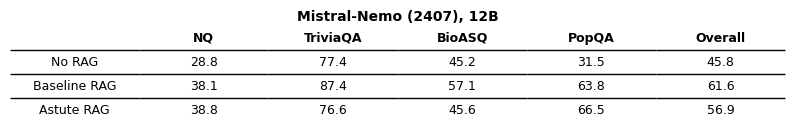

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 준비
data = {
    'NQ': [0, 0, 0],
    'TriviaQA': [0, 0, 0],
    'BioASQ': [0, 0, 0],
    'PopQA': [0, 0, 0],
    'Overall': [0, 0, 0]
}

#No RAG 정확도 업데이트
for key in data:
    acc = no_rag_accuracy[str(key).lower()]
    data[key][0] = round(acc, 1)
    
# Baseline RAG 정확도로 업데이트
for key in data:
    acc = rag_accuracy[str(key).lower()]
    data[key][1] = round(acc, 1)  

# Astute RAG 정확도로 업데이트
for key in data:
    acc = acc_with_astute_rag[str(key).lower()]
    data[key][2] = round(acc, 1)

df = pd.DataFrame(data, index=['No RAG', 'Baseline RAG', 'Astute RAG'])

fig, ax = plt.subplots(figsize=(8, 1.5))
ax.axis('off')

col_labels = [''] + list(df.columns)
header_text = [['Mistral-Nemo (2407), 12B', '', '', '', '']]

table = ax.table(
    cellText=[[idx] + list(row) for idx, row in zip(df.index, df.values)],
    colLabels=col_labels,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)

for j in range(len(col_labels)):
    table[(0, j)].set_facecolor('#ffffff')
    table[(0, j)].set_text_props(fontweight='bold')
    table[(0, j)].visible_edges = 'B' 

for i in range(1, len(df) + 1):
    for j in range(len(col_labels)):
        table[(i, j)].set_facecolor('#ffffff')
        table[(i, j)].visible_edges = 'B' if i < len(df) else ''

plt.text(0.5, 0.95, 'Mistral-Nemo (2407), 12B', ha='center', va='bottom', 
         fontsize=10, fontweight='bold', transform=ax.transAxes)

plt.tight_layout()
plt.show()